In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from tensorflow.keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

In [2]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages\Cat\0.jpg 0


In [3]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

images  label
0  PetImages\Cat\10545.jpg      0
1  PetImages\Cat\10369.jpg      0
2   PetImages\Cat\8296.jpg      0
3   PetImages\Dog\2110.jpg      1
4   PetImages\Cat\7088.jpg      0

In [4]:
for i in df['images']:
    if '.jpg' not in i:
        print(i)

PetImages\Dog\Thumbs.db
PetImages\Cat\Thumbs.db


In [6]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

['PetImages\\Dog\\Thumbs.db',
 'PetImages\\Dog\\11702.jpg',
 'PetImages\\Cat\\666.jpg',
 'PetImages\\Cat\\Thumbs.db']

In [8]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

25002

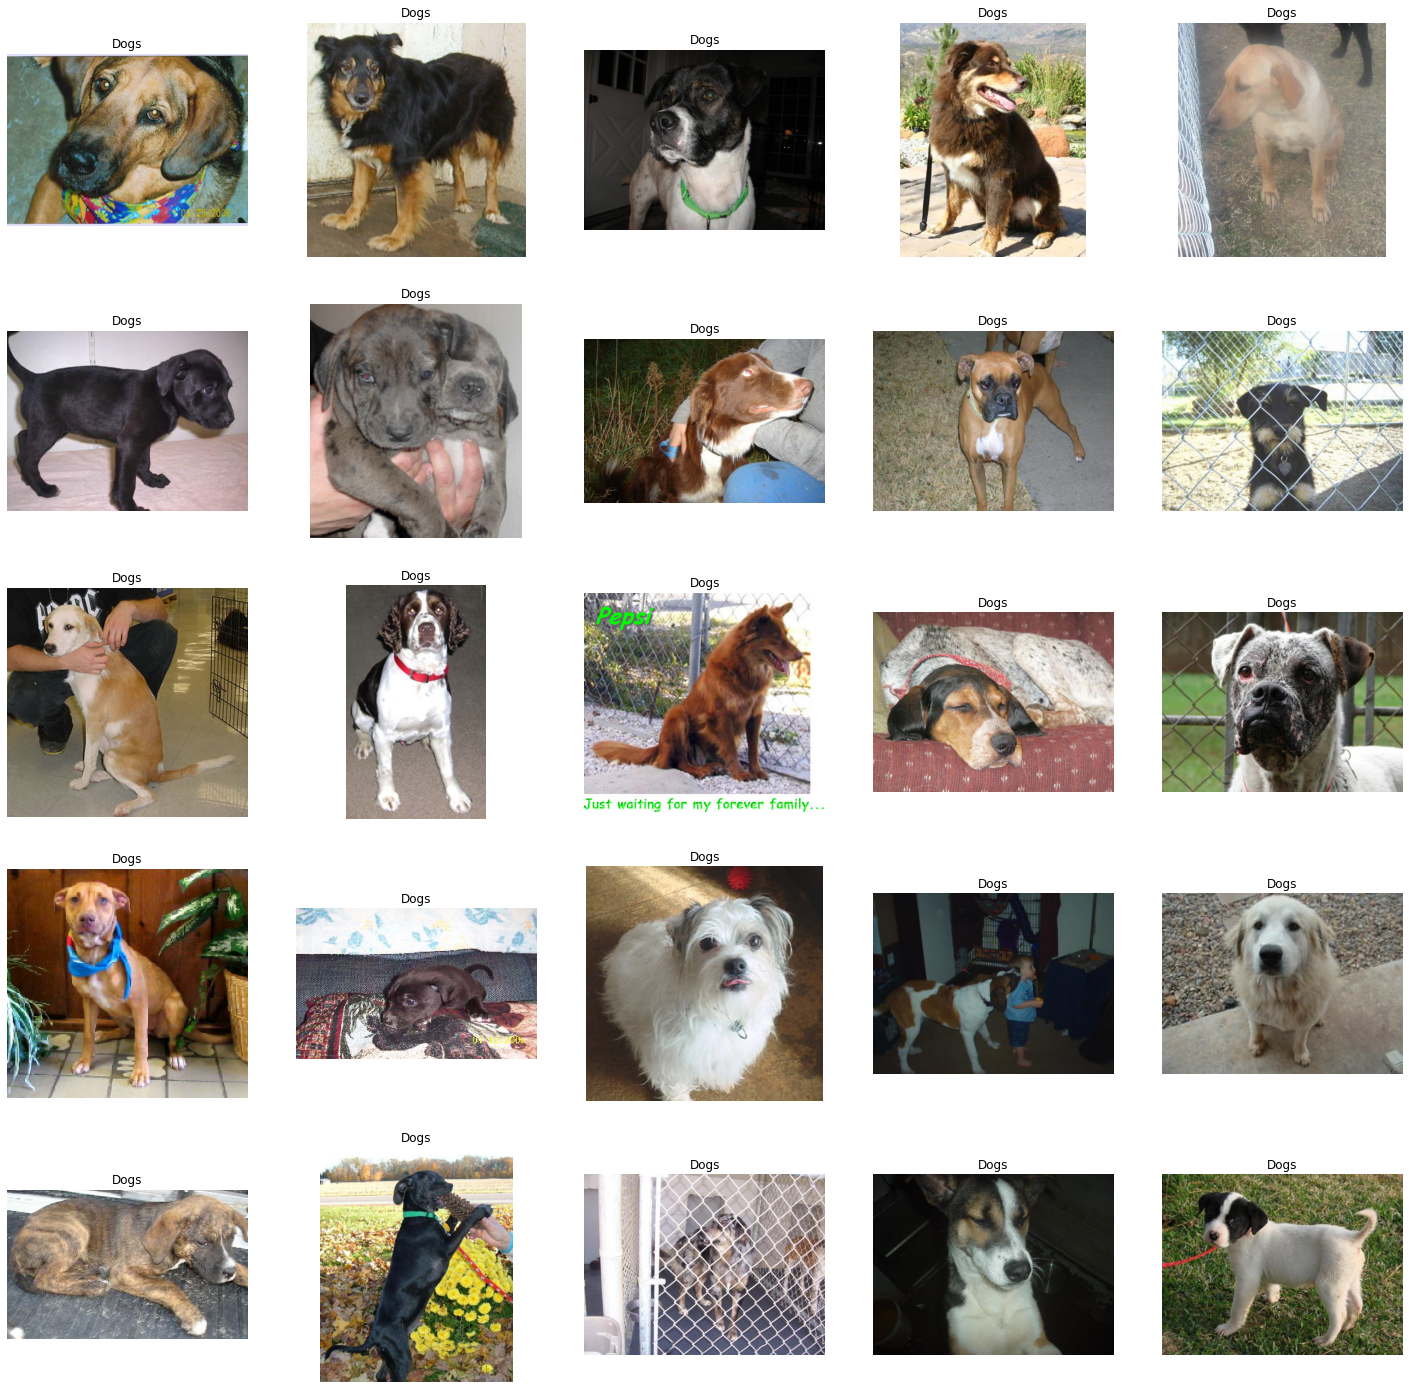

In [9]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Dogs')
    plt.axis('off')

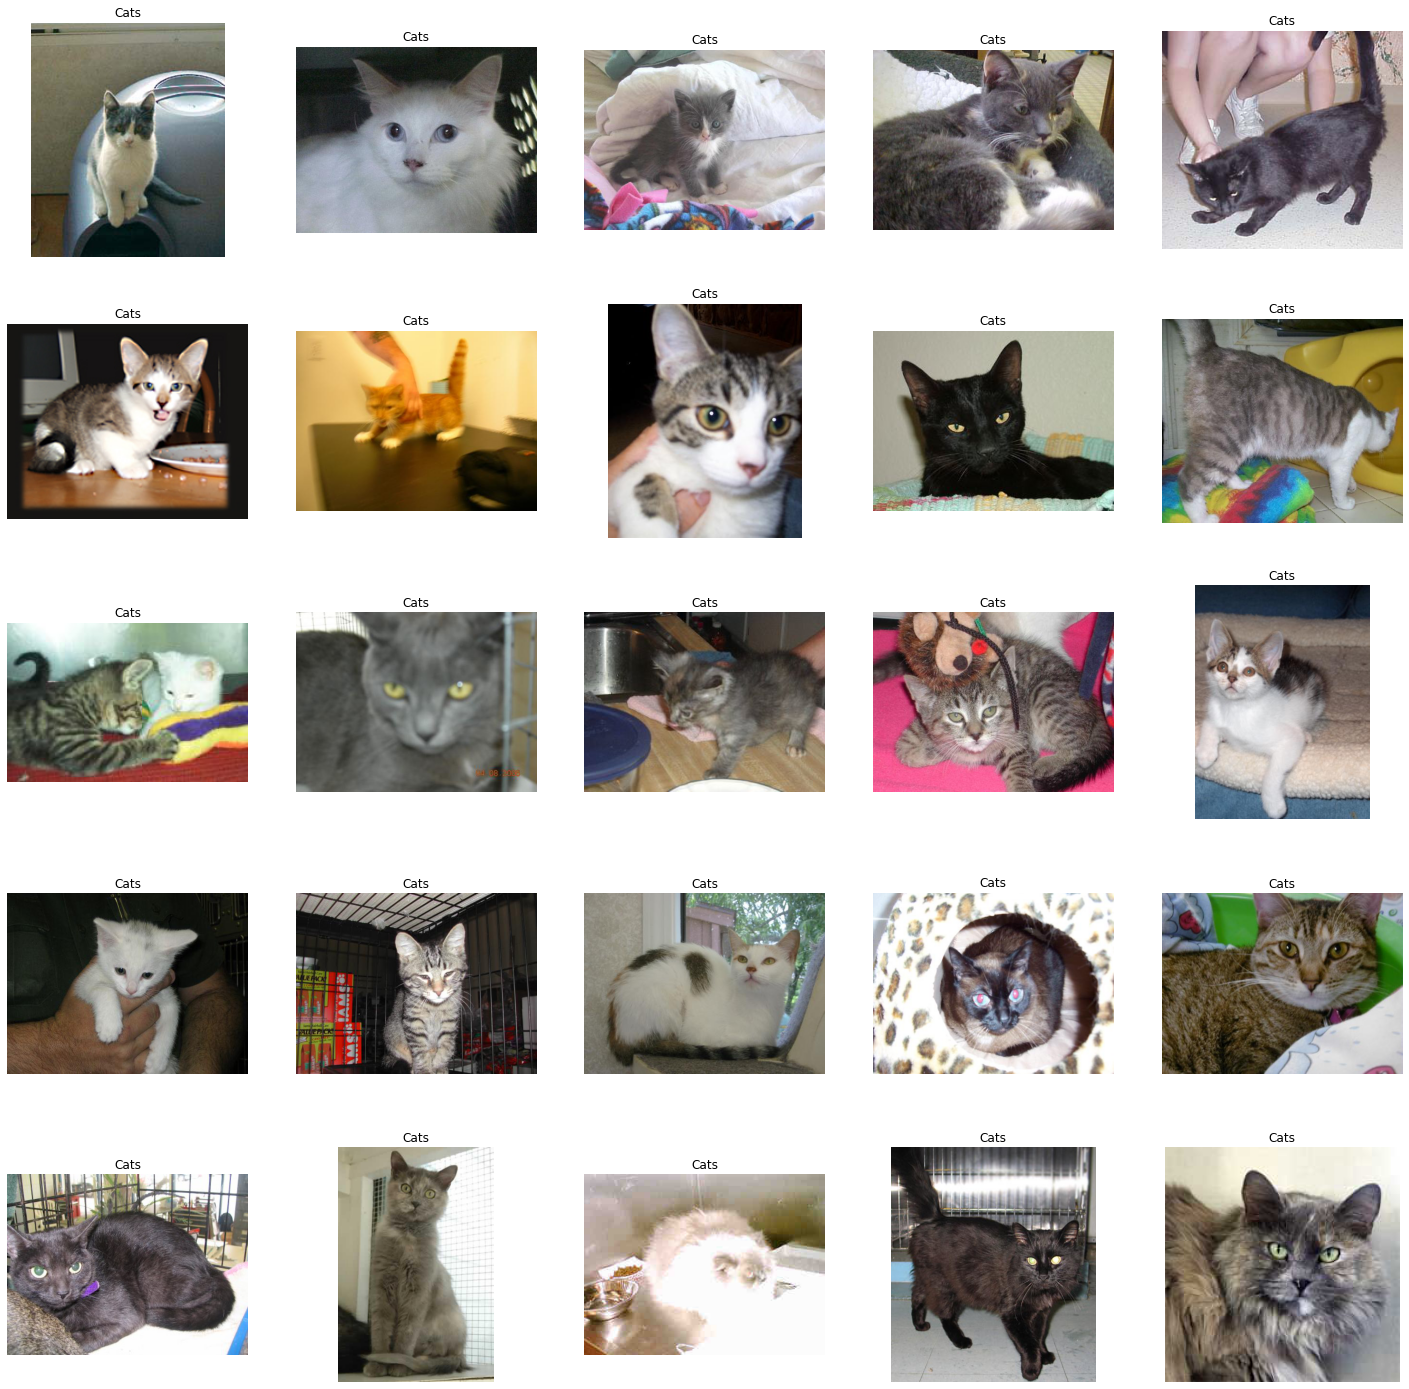

In [10]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cats')
    plt.axis('off')

<AxesSubplot:xlabel='label', ylabel='count'>

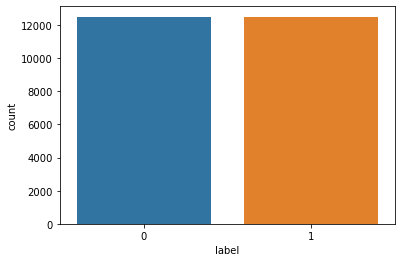

In [11]:
import seaborn as sns
sns.countplot(df['label'])

In [19]:
#create data generator for images

df['label'] = df['label'].astype('str')

In [20]:
df.head()

images label
0  PetImages\Cat\10545.jpg     0
1  PetImages\Cat\10369.jpg     0
2   PetImages\Cat\8296.jpg     0
3   PetImages\Dog\2110.jpg     1
4   PetImages\Cat\7088.jpg     0

In [21]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [22]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(128,128), 
    batch_size=512, 
    class_mode='binary'
)

Found 19997 validated image filenames belonging to 2 classes.
Found 5001 validated image filenames belonging to 2 classes.


In [23]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D((2,2)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPool2D((2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dense(1, activation='sigmoid')
])

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

In [25]:
history = model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10
40/40 [==============================] - 584s 15s/step - loss: 0.7351 - accuracy: 0.5399 - val_loss: 0.6467 - val_accuracy: 0.6145
Epoch 2/10
40/40 [==============================] - 247s 6s/step - loss: 0.6265 - accuracy: 0.6428 - val_loss: 0.6207 - val_accuracy: 0.6475
Epoch 3/10
40/40 [==============================] - 377s 9s/step - loss: 0.5741 - accuracy: 0.6996 - val_loss: 0.5486 - val_accuracy: 0.7137
Epoch 4/10
40/40 [==============================] - 277s 7s/step - loss: 0.5535 - accuracy: 0.7153 - val_loss: 0.5375 - val_accuracy: 0.7279
Epoch 5/10
40/40 [==============================] - 281s 7s/step - loss: 0.5419 - accuracy: 0.7233 - val_loss: 0.5060 - val_accuracy: 0.7526
Epoch 6/10
40/40 [==============================] - 284s 7s/step - loss: 0.5404 - accuracy: 0.7256 - val_loss: 0.4921 - val_accuracy: 0.7608
Epoch 7/10
40/40 [==============================] - 288s 7s/step - loss: 0.5137 - accuracy: 0.7449 - val_loss: 0.4879 - val_accuracy: 0.7628
Epoch 8/10
4

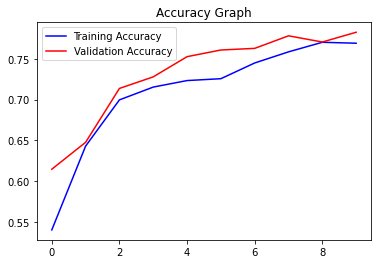

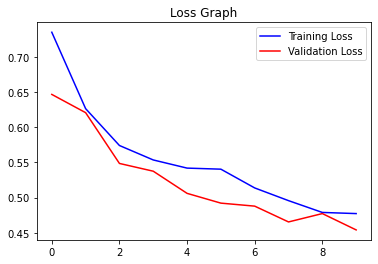

In [26]:
#visualization of result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [28]:
#testing with real image
image_path = "PetImages/cat/100.jpg" # path of the image
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0 # normalize the image
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)
if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)

1/1 [==============================] - 0s 32ms/step
Dog
